# MNIST

Modified NIST (MNIST): corpus de imágenes en gris de dígitos manuscritos

Partición estándar: primeras muestras para training y restantes para test

Tarea muy popular: desde su introducción en los 90, MNIST ha sido muy usado como tarea para comparar técnicas de ML

Tarea "agotada": pues ya se han alcanzado tasas de error muy reducidas.

Más info: https://en.wikipedia.org/wiki/MNIST_database

In [2]:
import numpy as np; from sklearn.datasets import fetch_openml

mnist_784_X, mnist_784_y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False, parser='auto')

X_train = mnist_784_X[:60000].astype(np.float32); y_train = mnist_784_y[:60000].astype(np.uint8)
X_test = mnist_784_X[60000:].astype(np.float32); y_test = mnist_784_y[60000:].astype(np.uint8)
X_train /= 255; X_test /= 255 # normalización a [0,1]

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(60000, 784) (60000,) (10000, 784) (10000,)


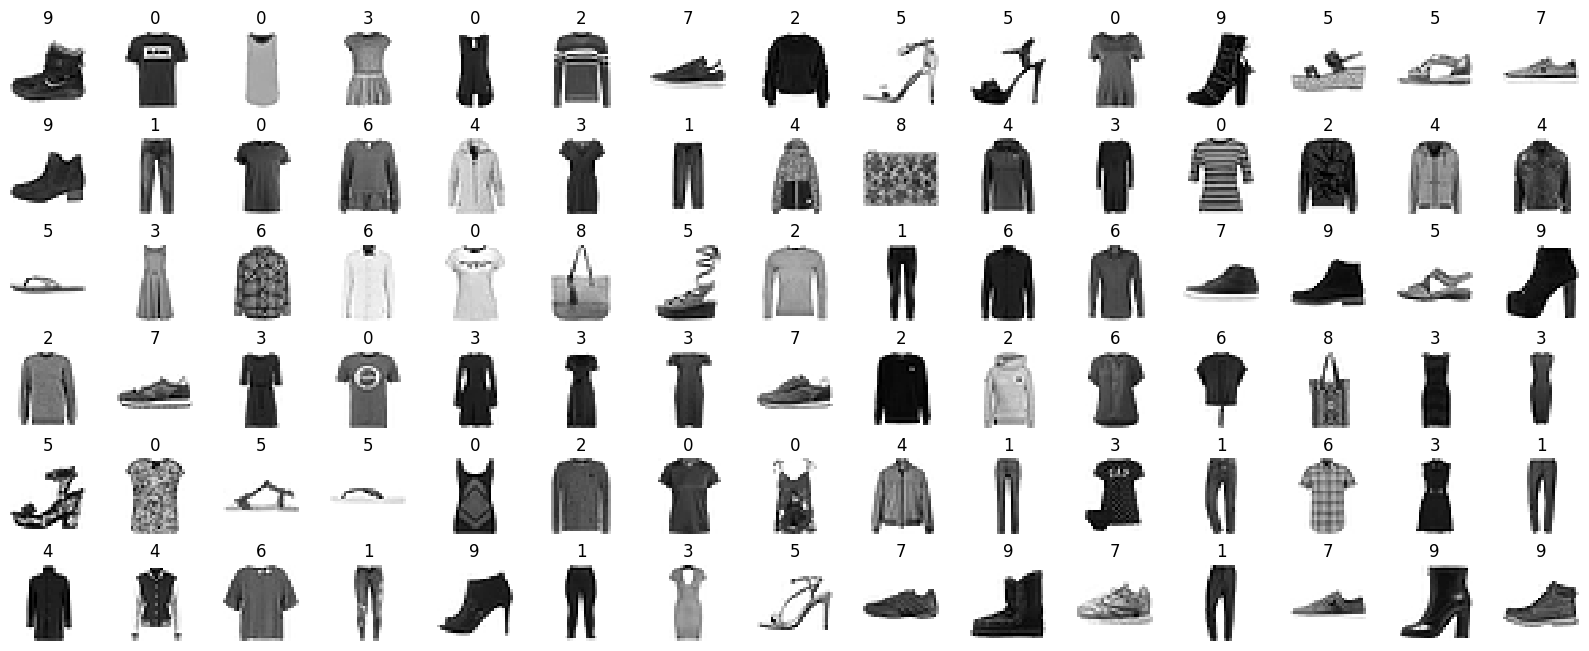

In [3]:
import matplotlib.pyplot as plt # type: ignore
nrows = 6; ncols = 15
_, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 16*nrows/ncols), constrained_layout=True)

for ax, x, y in zip(axs.flat, X_train, y_train):
  ax.set_axis_off(); image = x.reshape(28, 28); ax.set_title(y)
  ax.imshow(image, cmap=plt.cm.gray_r, interpolation="none")

#  Modelos lineales generativos

**Notación** : $ x \in \mathbb{R}^D \text{  y  } \;y \in {1, ... , C} $

Clasificador generativo: **expresa posteriors en función de priors y densidades condicionales de las clases, las cuales
puede muestrearse para generar datos sintéticos**

$ p\left( y=c | x, \theta \right) = \dfrac{p\left( y=c | x, \theta \right)p(y=c, \theta)}{\sum_{c'}{p\left( y=c | x, \theta \right)p(y=c', \theta)}}  \propto p\left( y=c | x, \theta \right)p(y=c, \theta)$

Linealidad: la log-posterior suele ser lineal con x, aunque en algunos casos es cuadrática.
 
Ajuste: la maximización de la log-verosimilitud conjunta suele conducir a estimadores fáciles de calcular.

- Los prior de las clases se estiman como frecuencias relativas $ \hat{\pi}_{c} = N_{c}/N $
- Los parámetros de cada clase se estiman con sus datos de entrenamiento.

In [1]:
import numpy as np; from sklearn.datasets import fetch_openml
mnist_784_X, mnist_784_y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False, parser='auto')

X_train = mnist_784_X[:60000].astype(np.float32); y_train = mnist_784_y[:60000].astype(np.uint8)
X_test = mnist_784_X[60000:].astype(np.float32); y_test = mnist_784_y[60000:].astype(np.uint8)
X_train /= 255; X_test /= 255 # normalización a [0,1]

In [2]:
import warnings; warnings.filterwarnings('ignore'); from sklearn.metrics import accuracy_score

## Naive Bayes

Clasificador naive Bayes Gaussiano (GNB): media y varianza de la característica **d en c**

$ p(x | y = c, \theta_c) = \prod_{d = 1}^D{N(x_d  |  \mu_{cd} , \sigma^2_{cd})} \text{    donde...} $

$ \theta_{c} =(\theta_{c1}, ... \theta_{cD})^t, \theta_{cd} = (\mu_{cd}, \sigma²_{cd}) $

$ \hat{\mu}_{cd} = \dfrac{1}{N_c} \sum{x_{nd}}$

$ \hat{\sigma}_{cd}² = \dfrac{1}{N_c} \left(\sum{x_{nd} - \hat{\mu}_{cd} } \right)$



In [6]:
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB(var_smoothing=1e-9).fit(X_train, y_train)
acc = accuracy_score(y_test, clf.predict(X_test))
print(f'La precisión de {clf!s} es {acc:.1%}')

La precisión de GaussianNB() es 55.6%


## Análisis discriminante lineal (LDA)

El Análisis Discriminante Lineal (LDA) es un algoritmo de reducción de dimensionalidad y de clasificación supervisada. El LDA busca proyectar los datos en un espacio de menor dimensionalidad de tal manera que se maximice la separación entre las clases.

$ \begin{aligned}
\mathbf{w}_{opt} &= \arg \max_{\mathbf{w}} \frac{\mathbf{w}^T \mathbf{S}_B \mathbf{w}}{\mathbf{w}^T \mathbf{S}_W \mathbf{w}} \\
&= \mathbf{S}_W^{-1} \mathbf{S}_B \mathbf{w}
\end{aligned} $

Donde $\mathbf{S}_B$ es la matriz de covarianza entre las clases y $\mathbf{S}_W$ es la matriz de covarianza dentro de las clases. El vector $\mathbf{w}_{opt}$ es el que maximiza la separación entre las clases en el espacio proyectado.

In [7]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

clf = LinearDiscriminantAnalysis(tol=1e-4).fit(X_train, y_train)
acc = accuracy_score(y_test, clf.predict(X_test))
print(f'La precisión de {clf!s} es {acc:.1%}')

La precisión de LinearDiscriminantAnalysis() es 87.3%


## Análisis discriminante cuadrático (QDA)

El Análisis Discriminante Cuadrático (QDA) es un algoritmo de clasificación supervisada que busca separar las clases mediante una cuadrática en el espacio de caracteristicas. El QDA asume que las distribuciones de las clases son gaussianas con matrices de covarianza diferentes entre las clases. La función de decisión del QDA se define como:

Donde $\mu_c$ es el vector de medias de la clase $c$, $\mathbf{\Sigma}_c$ es la matriz de covarianza de la clase $c$ y $\pi_c$ es la probabilidad a priori de la clase $c$. La clase predicha para una observación $x$ es la clase que maximiza $\delta_c(x)$.

In [8]:
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
pca = PCA(); qda = QuadraticDiscriminantAnalysis()

pipe = Pipeline(steps=[("pca", pca), ("qda", qda)])
G = {"pca__n_components": [60, 70, 80, None], "qda__reg_param": [0.01, 0.02, 0.05]}
GS = GridSearchCV(pipe, G, scoring='accuracy', refit=True, cv=5)
acc = GS.fit(X_train, y_train).score(X_test, y_test)
print(f'Precisión: {acc:.1%} con {GS.best_params_}')

Precisión: 96.6% con {'pca__n_components': 70, 'qda__reg_param': 0.02}


# Modelos lineales discriminativos

Clasificador discriminativo: modela posteriors directamente, **sin modelar priors ni densidades condicionales**.




In [9]:
import numpy as np; from sklearn.datasets import fetch_openml
mnist_784_X, mnist_784_y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False, parser='auto')
X_train = mnist_784_X[:60000].astype(np.float32); y_train = mnist_784_y[:60000].astype(np.uint8)
X_test = mnist_784_X[60000:].astype(np.float32); y_test = mnist_784_y[60000:].astype(np.uint8)
X_train /= 255; X_test /= 255 # normalización a [0,1]

## Regresión logística

In [10]:
from sklearn.linear_model import LogisticRegression; from sklearn.model_selection import GridSearchCV
G = {"solver": ["lbfgs"], "tol": [1e-4], "C": [1], "max_iter": [100]}
GS = GridSearchCV(LogisticRegression(random_state=23), G, scoring='accuracy', refit=True, cv=5)
acc = GS.fit(X_train, y_train).score(X_test, y_test)
print(f'Precisión: {acc:.1%} con {GS.best_params_}')

Precisión: 92.6% con {'C': 1, 'max_iter': 100, 'solver': 'lbfgs', 'tol': 0.0001}


## Ingeniería de características

In [11]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
pca = PCA(); poly = PolynomialFeatures(); scaler = StandardScaler(); logreg = LogisticRegression()
pipe = Pipeline(steps=[("pca", pca), ("poly", poly), ("scaler", scaler), ("logreg", logreg)])
G = {"pca__n_components": [70], "poly__degree": [2], "logreg__C": [1]}
GS = GridSearchCV(pipe, G, scoring='accuracy', refit=True, cv=5)
acc = GS.fit(X_train, y_train).score(X_test, y_test)
print(f'Precisión: {acc:.1%} con {GS.best_params_}')


Precisión: 97.8% con {'logreg__C': 1, 'pca__n_components': 70, 'poly__degree': 2}


# Random Forests

In [12]:
import numpy as np; from sklearn.datasets import fetch_openml
mnist_784_X, mnist_784_y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False, parser='auto')
X_train = mnist_784_X[:60000].astype(np.float32); y_train = mnist_784_y[:60000].astype(np.uint8)
X_test = mnist_784_X[60000:].astype(np.float32); y_test = mnist_784_y[60000:].astype(np.uint8)
X_train /= 255; X_test /= 255 # normalización a [0,1]

import warnings; warnings.filterwarnings('ignore'); from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier; from sklearn.model_selection import GridSearchCV
clf = RandomForestClassifier(random_state=23)
G = {"n_estimators": [100, 200, 300, 400, 500], "max_depth": [None]}
GS = GridSearchCV(clf, G, scoring='accuracy', refit=True, cv=5, verbose=1)
acc = GS.fit(X_train, y_train).score(X_test, y_test)
print(f'Precisión: {acc:.1%} con {GS.best_params_}')


# Boosting

In [ ]:
import numpy as np; from sklearn.datasets import fetch_openml
mnist_784_X, mnist_784_y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False, parser='auto')
X_train = mnist_784_X[:60000].astype(np.float32); y_train = mnist_784_y[:60000].astype(np.uint8)
X_test = mnist_784_X[60000:].astype(np.float32); y_test = mnist_784_y[60000:].astype(np.uint8)
X_train /= 255; X_test /= 255 # normalización a [0,1]

import warnings; warnings.filterwarnings('ignore'); from sklearn.metrics import accuracy_score
from sklearn.ensemble import HistGradientBoostingClassifier; from sklearn.model_selection import GridSearchCV
clf = HistGradientBoostingClassifier(random_state=23)
G = {"max_depth": [4, 8, 16, None]}
GS = GridSearchCV(clf, G, scoring='accuracy', refit=True, cv=5, verbose=1)
acc = GS.fit(X_train, y_train).score(X_test, y_test)
print(f'Precisión: {acc:.1%} con {GS.best_params_}')

# Fashion-MNIST

# Explicación del Código para Visualización de Fashion-MNIST

Este código carga el conjunto de datos *Fashion-MNIST*, lo procesa y luego visualiza algunas imágenes con sus etiquetas. A continuación se describe cada paso en detalle.

### 1. Carga de Datos

Se utiliza la función fetch_openml de sklearn.datasets para descargar el conjunto de datos Fashion-MNIST desde la plataforma OpenML. 
Esto da como resultado:
 - fashion_mnist_X: Las imágenes.
 - fashion_mnist_y: Las etiquetas correspondientes.

### 2. División de Datos
Se dividen los datos en conjuntos de entrenamiento y prueba:
 - X_train y y_train: Las primeras 60,000 imágenes y etiquetas para entrenamiento.
 - X_test y y_test: Las restantes 10,000 imágenes y etiquetas para prueba.

Los valores de los píxeles se normalizan al rango [0, 1] dividiendo entre 255 (el valor máximo de un píxel en escala de grises).

### 4. Definición de Etiquetas
labels = ('T-Shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

Las etiquetas corresponden a las categorías del conjunto de datos Fashion-MNIST, que incluye 10 clases de ropa y accesorios.

### 5. Configuración de Visualización
```python
nrows = 2

ncols = 10
_, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 16*nrows/ncols), constrained_layout=True)
```
Se crea un lienzo con 2 filas y 10 columnas (20 subplots en total) para visualizar una selección de imágenes.

### 6. Despliegue de Imágenes y Etiquetas

```python
for ax, x, y in zip(axs.flat, X_train, y_train):
    ax.set_axis_off()
    image = x.reshape(28, 28)
    ax.set_title(labels[y])
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation="none")
```
Este bucle:
 - Recorre los subplots y coloca una imagen de X_train en cada uno.
 - x.reshape(28, 28) convierte una imagen de 784 píxeles (28x28) en una matriz.
- ax.imshow(image, cmap=plt.cm.gray_r, interpolation="none") despliega la imagen en escala de grises sin interpolación.
- ax.set_title(labels[y]) muestra el nombre de la clase correspondiente sobre cada imagen.


In [ ]:
import numpy as np
from sklearn.datasets import fetch_openml
fashion_mnist_X, fashion_mnist_y = fetch_openml('Fashion-MNIST', return_X_y=True, as_frame=False, parser='auto')
X_train = fashion_mnist_X[:60000].astype(np.float32); y_train = fashion_mnist_y[:60000].astype(np.uint8)
X_test = fashion_mnist_X[60000:].astype(np.float32); y_test = fashion_mnist_y[60000:].astype(np.uint8)
X_train /= 255; X_test /= 255 # normalización a [0,1]
labels = ('T-Shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

nrows = 2; ncols = 10
_, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 16*nrows/ncols), constrained_layout=True)
for ax, x, y in zip(axs.flat, X_train, y_train):
    ax.set_axis_off(); image = x.reshape(28, 28); ax.set_title(labels[y])
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation="none")

### Ejercicio

# Explicación del Código para Optimización de Parámetros con GridSearchCV y HistGradientBoostingClassifier

Este código utiliza `GridSearchCV` para encontrar los mejores parámetros en un modelo `HistGradientBoostingClassifier`. Se explican los pasos clave a continuación:

1. **Definición del Modelo**:
   - Se crea una instancia del clasificador `HistGradientBoostingClassifier` de `sklearn.ensemble`, configurado con `random_state=23` para asegurar la reproducibilidad.

2. **Definición del Espacio de Búsqueda de Parámetros**:
   - La variable `G` define un diccionario de hiperparámetros que `GridSearchCV` explorará. Aquí, se varía el valor de `max_depth` en `[4, 8, 16, None]` para probar distintas profundidades máximas del árbol en el modelo.

3. **Configuración de `GridSearchCV`**:
   - Se crea una instancia de `GridSearchCV` (`GS`) con el clasificador, los parámetros de `G`, y configurada para:
     - Optimizar usando la métrica `accuracy`.
     - Reajustar el modelo con los mejores parámetros (`refit=True`).
     - Realizar una validación cruzada de 5 pliegues (`cv=5`).
     - Mostrar el progreso con `verbose=1`.

4. **Ajuste del Modelo y Evaluación de Precisión**:
   - `GS.fit(X_train, y_train)` ajusta el modelo con los datos de entrenamiento, probando los diferentes valores de `max_depth`.
   - `GS.score(X_test, y_test)` evalúa el rendimiento del modelo óptimo en el conjunto de prueba.
   - Finalmente, se imprime la precisión obtenida y los mejores parámetros encontrados.



In [ ]:
from sklearn.ensemble import HistGradientBoostingClassifier
clf = HistGradientBoostingClassifier(random_state=23)
G = {"max_depth": [4, 8, 16, None]}
GS = GridSearchCV(clf, G, scoring='accuracy', refit=True, cv=5, verbose=1)
acc = GS.fit(X_train, y_train).score(X_test, y_test)
print(f'Precisión: {acc:.1%} con {GS.best_params_}')

# Explicación del Código para Optimización de Parámetros con GridSearchCV y RandomForestClassifier

Este código emplea `GridSearchCV` para encontrar los mejores hiperparámetros de un modelo `RandomForestClassifier`. A continuación se detallan los pasos:

1. **Definición del Modelo**:
   - Se crea una instancia del clasificador `RandomForestClassifier` de `sklearn.ensemble`, configurado con `random_state=23` para obtener resultados reproducibles.

2. **Definición del Espacio de Búsqueda de Parámetros**:
   - La variable `G` es un diccionario de hiperparámetros que especifica los valores que `GridSearchCV` evaluará:
     - `n_estimators`: Número de árboles en el bosque, variando entre `[100, 200, 300, 400, 500]`.
     - `max_depth`: Profundidad máxima de los árboles, fijada en `None` para que los árboles crezcan completamente.

3. **Configuración de `GridSearchCV`**:
   - Se crea la instancia `GS` de `GridSearchCV`, configurada para:
     - Optimizar la métrica `accuracy`.
     - Reajustar el modelo con los mejores parámetros (`refit=True`).
     - Usar validación cruzada de 5 pliegues (`cv=5`).
     - Mostrar el progreso con `verbose=1`.

4. **Ajuste del Modelo y Evaluación de Precisión**:
   - `GS.fit(X_train, y_train)` entrena el modelo con los datos de entrenamiento, probando distintas configuraciones de `n_estimators`.
   - `GS.score(X_test, y_test)` calcula la precisión del mejor modelo en el conjunto de prueba.
   - Finalmente, se imprime la precisión obtenida y los parámetros óptimos encontrados.



In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(random_state=23)
G = {"n_estimators": [100, 200, 300, 400, 500], "max_depth": [None]}
GS = GridSearchCV(clf, G, scoring='accuracy', refit=True, cv=5, verbose=1)
acc = GS.fit(X_train, y_train).score(X_test, y_test)
print(f'Precisión: {acc:.1%} con {GS.best_params_}')

# Explicación del Código para Optimización de Parámetros con GridSearchCV y Pipeline

Este código utiliza `GridSearchCV` para optimizar un pipeline de procesamiento y clasificación que incluye los pasos de reducción de dimensionalidad, expansión de características, escalado, y un clasificador de regresión logística. A continuación se explica cada parte y se destacan las diferencias respecto a los ejemplos anteriores.

## 1. Definición del Pipeline

Se construye un pipeline que contiene varios pasos:
- **PCA**: Realiza una reducción de dimensionalidad mediante Análisis de Componentes Principales.
- **PolynomialFeatures**: Expande las características del conjunto de datos creando combinaciones polinómicas de segundo grado.
- **StandardScaler**: Escala los datos para que tengan media 0 y desviación estándar 1, un paso importante para la correcta operación de la regresión logística.
- **LogisticRegression**: Clasificador que ajustará el modelo final.

**Este enfoque es diferente de los anteriores en que se encadenan múltiples etapas de preprocesamiento antes de entrenar el modelo, mientras que en los ejemplos anteriores solo se optimizaba el modelo final (clasificador)**.

## 2. Definición del Espacio de Búsqueda de Parámetros

Se define un diccionario que contiene los parámetros a explorar en cada paso del pipeline:
- **pca__n_components**: Número de componentes para PCA, fijado en 70 para reducir la dimensionalidad.
- **poly__degree**: Grado del polinomio a crear con `PolynomialFeatures`, establecido en 2 para una expansión cuadrática.
- **logreg__C**: Valor de regularización en `LogisticRegression`, fijado en 1.

En comparación con los ejemplos anteriores, este pipeline permite optimizar varios pasos de procesamiento y modelado, en lugar de optimizar solo hiperparámetros del clasificador final.

## 3. Configuración de `GridSearchCV`

La función `GridSearchCV` se aplica al pipeline completo:
- Evalúa el modelo mediante la métrica `accuracy` con validación cruzada de 5 pliegues.
- Reajusta el pipeline con los mejores parámetros al finalizar (`refit=True`).

En los ejemplos anteriores, `GridSearchCV` solo optimizaba parámetros del clasificador, mientras que aquí, la optimización se extiende a los pasos de preprocesamiento y modelado.

## 4. Ajuste del Modelo y Evaluación de Precisión

Una vez configurado, `GridSearchCV` ajusta el pipeline completo usando los datos de entrenamiento. Posteriormente, el modelo ajustado se evalúa en el conjunto de prueba para calcular la precisión final (`accuracy`) y encontrar los mejores parámetros del pipeline. 

Este proceso de ajuste y evaluación permite seleccionar la combinación óptima de parámetros en todos los pasos del pipeline, logrando un modelo robusto y bien afinado.


In [ ]:
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
pca = PCA(); poly = PolynomialFeatures(); scaler = StandardScaler(); logreg = LogisticRegression()
pipe = Pipeline(steps=[("pca", pca), ("poly", poly), ("scaler", scaler), ("logreg", logreg)])
G = {"pca__n_components": [70], "poly__degree": [2], "logreg__C": [1]}
GS = GridSearchCV(pipe, G, scoring='accuracy', refit=True, cv=5)
acc = GS.fit(X_train, y_train).score(X_test, y_test)
print(f'Precisión: {acc:.1%} con {GS.best_params_}')

# Explicación del Código para Optimización de Parámetros con GridSearchCV y LogisticRegression

Este código utiliza `GridSearchCV` para optimizar los hiperparámetros de un modelo `LogisticRegression` para clasificación. A continuación se detallan los pasos y configuraciones.

## 1. Definición del Modelo

Se crea una instancia de `LogisticRegression`, configurada con `random_state=23` para asegurar la reproducibilidad. La regresión logística es un modelo lineal adecuado para clasificación binaria y multiclase, y su precisión puede mejorarse ajustando algunos de sus hiperparámetros.

## 2. Definición del Espacio de Búsqueda de Parámetros

El diccionario `G` especifica los valores que `GridSearchCV` evaluará para optimizar el modelo:
- **solver**: Método para optimizar el modelo, configurado como `"lbfgs"`, que es un algoritmo de optimización adecuado para problemas con gran cantidad de datos.
- **tol**: Tolerancia para la convergencia, fijada en `1e-4`, que controla la precisión requerida antes de detener la optimización.
- **C**: Parámetro de regularización, establecido en `1`, que determina la penalización aplicada a la magnitud de los coeficientes del modelo.
- **max_iter**: Número máximo de iteraciones para que el algoritmo converja, fijado en `100`.

Al usar este conjunto de valores, se busca encontrar una configuración de parámetros que logre el mejor rendimiento en términos de precisión.

## 3. Configuración de `GridSearchCV`

`GridSearchCV` se aplica a la instancia de `LogisticRegression`, y se configura para:
- Usar `accuracy` como métrica de evaluación.
- Reajustar el modelo con los mejores parámetros después de la búsqueda (`refit=True`).
- Utilizar validación cruzada de 5 pliegues (`cv=5`) para evaluar el rendimiento del modelo en varios subconjuntos de datos y evitar el sobreajuste.

En comparación con ejemplos anteriores que usaban modelos complejos o pipelines, aquí se optimiza un solo modelo con hiperparámetros básicos, lo que reduce la complejidad de la búsqueda.

## 4. Ajuste del Modelo y Evaluación de Precisión

El modelo ajustado por `GridSearchCV` se entrena usando los datos de entrenamiento y se evalúa en el conjunto de prueba:
- La precisión obtenida representa el rendimiento del mejor modelo en el conjunto de prueba.
- Finalmente, se imprime la precisión lograda junto con los mejores parámetros encontrados, permitiendo ver la combinación de hiperparámetros óptima para el modelo `LogisticRegression`.


In [ ]:
from sklearn.linear_model import LogisticRegression
G = {"solver": ["lbfgs"], "tol": [1e-4], "C": [1], "max_iter": [100]}
GS = GridSearchCV(LogisticRegression(random_state=23), G, scoring='accuracy', refit=True, cv=5)
acc = GS.fit(X_train, y_train).score(X_test, y_test)
print(f'Precisión: {acc:.1%} con {GS.best_params_}')